# Artificial-Intelligence-Software-For-Diagnosis-Of-Cardiovascular-Diseases
Graduation Project of faculty of Computer Science at Ain Shams University 2023


# import libraries

In [1]:
# import nessary libraries
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath
import pandas as pd

import wfdb
from wfdb import processing
from scipy import signal

# Datasets division

## EDA & Signal Segmentations

### Information of four databases of ECGs used.
<img src="https://ieeexplore.ieee.org/mediastore_new/IEEE/content/media/5971803/9906039/9906046/386-404-table-4-source-small.gif">

#### 1- load data of each disease
    MIT-BIH NSRDB => Normal
    St INCARTDB   => CAD
    PTBDB         => MI
    BIDMC CHFDB   => CHF
    
#### 2- select channel 
    ECG1 and ECG2 leads => MIT-BIH NSRDB, BIDMC CHFDB 
    II and V1 leads     => St INCARTDB, PTBDB

#### 3- visualize 500 sample of each channle

#### 4- Resample data by convert Fs to 250 HZ in all data

##### `Helper Functions`

In [2]:
def resample(path, ann, channelsName, channelsNum):
    record = wfdb.rdrecord(path, channels=channelsNum)
    ann_ref = wfdb.rdann(path,ann)
    print("Shape of signal Before Resampling => ", record.p_signal.shape)
    resampled_sig = wfdb.processing.resample_multichan(record.p_signal, ann_ref, record.fs, 250, resamp_ann_chan=0)[0]  # this retrun p_singal , annotation
    print("Shape of signal After Resampling  => ", resampled_sig.shape)
    resampled_df = pd.DataFrame(resampled_sig, columns=channelsName)
    resampled_df.iloc[:500,:].plot();
    return resampled_df

#### `MIT-BIH NSRDB => Normal`

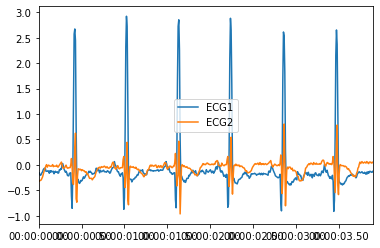

In [3]:
record = wfdb.rdrecord('mit-bih-normal-sinus-rhythm-database-1.0.0/16265', sampto=500)
df = record.to_dataframe()
df.plot();

Shape of signal Before Resampling =>  (11730944, 2)
Shape of signal After Resampling  =>  (22912000, 2)


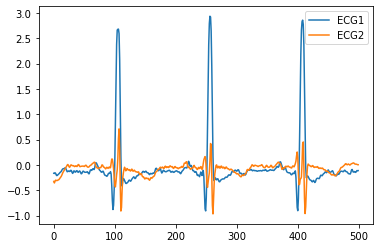

In [4]:
normal_df = resample('mit-bih-normal-sinus-rhythm-database-1.0.0/16265', 'atr', ['ECG1', 'ECG2'], [0,1])

#### `St INCARTDB   => CAD`

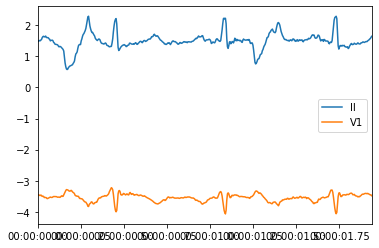

In [5]:
record = wfdb.rdrecord('st-petersburg-incart-12-lead-arrhythmia-database-1.0.0/files/I01', sampto=500, channels=[1,6])
df = record.to_dataframe()
df.plot();

Shape of signal Before Resampling =>  (462600, 2)
Shape of signal After Resampling  =>  (450000, 2)


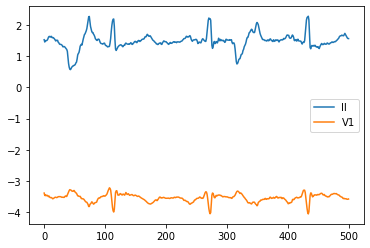

In [6]:
CAD_df = resample('st-petersburg-incart-12-lead-arrhythmia-database-1.0.0/files/I01', 'atr', ['II', 'V1'], [1,6])

#### `PTBDB         => MI`

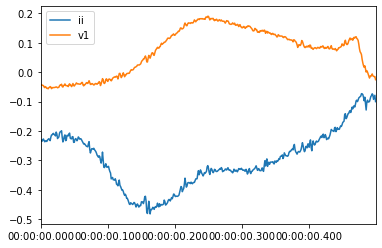

In [7]:
record = wfdb.rdrecord('ptb-diagnostic-ecg-database-1.0.0/patient001/s0010_re', sampto=500, channels=[1,6])
df = record.to_dataframe()
df.plot();

Shape of signal Before Resampling =>  (38400, 2)
Shape of signal After Resampling  =>  (9600, 2)


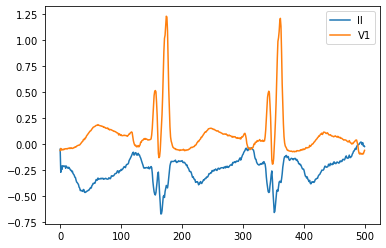

In [8]:
MI_df = resample('ptb-diagnostic-ecg-database-1.0.0/patient001/s0010_re', 'xyz', ['II', 'V1'], [1,6])

#### `BIDMC CHFDB   => CHF`

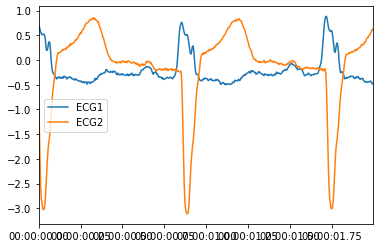

In [9]:
record = wfdb.rdrecord('bidmc-congestive-heart-failure-database-1.0.0/files/chf01', sampto=500)
df = record.to_dataframe()
df.plot();

Shape of signal Before Resampling =>  (17994491, 2)
Shape of signal After Resampling  =>  (17994491, 2)


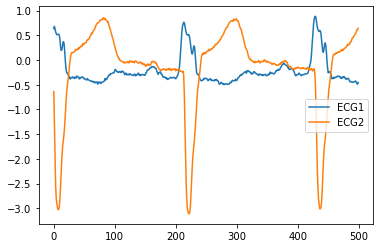

In [10]:
CHF_df = resample('bidmc-congestive-heart-failure-database-1.0.0/files/chf01', 'ecg', ['ECG1', 'ECG2'], [0,1])

## Note on Datasets division

### Note
#### The project was divided into several datasets including division:
- two-classification
- three-classification experimental
- four-classification
#### to verify the effectiveness of the network model in dealing with multi-classification problems.

#### Nine datasets (A–I) were divided for the demonstration of the experiments.
    1- Datasets A–F and G–I were used for intra-patient and inter-patient classification experiments for normal, CAD, MI, and CHF, respectively.
    2- We selected the same data points from each ECG signal to construct balanced Datasets A–C. In addition,

##### Information of balanced datasets for intra-patient experiments.
<img src="https://ieeexplore.ieee.org/mediastore_new/IEEE/content/media/5971803/9906039/9906046/386-404-table-5-source-small.gif">

##### Information of unbalanced datasets for intrapatient experiments.
<img src="https://ieeexplore.ieee.org/mediastore_new/IEEE/content/media/5971803/9906039/9906046/386-404-table-6-source-small.gif">

##### Information of training datasets for inter-patient experiments.
<img src="https://ieeexplore.ieee.org/mediastore_new/IEEE/content/media/5971803/9906039/9906046/386-404-table-7-source-small.gif">

##### Information of test datasets for inter-patient experiments.
<img src="https://ieeexplore.ieee.org/mediastore_new/IEEE/content/media/5971803/9906039/9906046/386-404-table-8-source-small.gif">

#### Data input
    The ECG signals from two leads are used as input to verify the diagnostic rate of multi-lead data for diseases. The input data are presented as follows: 
    X=[x1,1,x1,2,…,x1,M,x2,1,x2,2,…,x2,N]


## Information of balanced datasets for intra-patient experiments.
<img src="https://ieeexplore.ieee.org/mediastore_new/IEEE/content/media/5971803/9906039/9906046/386-404-table-5-source-small.gif">

### `get 20,000 row and 1000 col from each class`

##### `Helper Functions`

In [11]:
# functions used in this section
def getSpecificData(df, rows, cols):
    class_arr = []
    index = 0
    for row in range(rows):
        col_arr, ch1, ch2 = [], [], [] 
        for col in range(cols):
            ch1.append(df.iloc[index, 0])
            ch2.append(df.iloc[index, 1])
            index += 1
        col_arr = ch1 + ch2
        class_arr.append(col_arr)
    return class_arr

#### 1- noraml class

In [12]:
# noraml case
normal_df.head()

,ECG1,ECG2
0,-0.165000,-0.325000
1,-0.168776,-0.355663
2,-0.154753,-0.323248
3,-0.167232,-0.300683
4,-0.197550,-0.305925


In [13]:
normal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22912000 entries, 0 to 22911999
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   ECG1    float64
 1   ECG2    float64
dtypes: float64(2)
memory usage: 349.6 MB


In [14]:
# so when do balanced dataset we determine 20,000 accordding to smallest dataset 
normal_df.shape[0] // 500

45824

In [15]:
normal_arr = getSpecificData(normal_df, 20000, 500)

In [16]:
len(normal_arr)

20000

In [17]:
len(normal_arr[0])

1000

In [18]:
y_normal = ['Normal'] * 20000

In [19]:
len(y_normal)

20000

In [20]:
normal_df = pd.DataFrame(normal_arr)

In [21]:
normal_df["output"] = y_normal 

In [22]:
normal_df.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,output
0,-0.165,-0.168776,-0.154753,-0.167232,-0.197550,-0.211124,-0.203330,-0.192482,-0.182924,-0.167898,...,0.040005,0.036932,0.024551,0.015507,0.014967,0.015231,0.010528,0.005157,0.004069,Normal
1,-0.095,-0.095048,-0.126793,-0.155823,-0.153653,-0.135525,-0.123970,-0.120646,-0.127472,-0.149239,...,0.014909,0.017073,0.011398,0.039112,0.072214,0.058382,0.026070,0.033727,0.055729,Normal
2,-0.225,-0.227019,-0.172131,-0.137099,-0.169868,-0.208958,-0.189195,-0.152097,-0.159166,-0.168301,...,-0.019895,-0.030023,-0.053879,-0.048298,-0.024235,-0.023480,-0.044136,-0.054878,-0.058138,Normal
3,-0.295,-0.276584,-0.254224,-0.248928,-0.255347,-0.247128,-0.221190,-0.203685,-0.206389,-0.210534,...,-0.195075,-0.212964,-0.218552,-0.215370,-0.217730,-0.233215,-0.249608,-0.254968,-0.255059,Normal
4,-0.165,-0.151894,-0.176458,-0.198733,-0.193563,-0.175446,-0.163983,-0.159482,-0.153436,-0.140339,...,-0.025875,-0.017300,-0.008837,-0.013961,-0.014726,0.003092,0.013856,-0.003781,-0.023318,Normal


In [23]:
normal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 1001 entries, 0 to output
dtypes: float64(1000), object(1)
memory usage: 152.7+ MB


#### 2- CAD class

Shape of signal Before Resampling =>  (462600, 2)
Shape of signal After Resampling  =>  (450000, 2)
Shape of signal Before Resampling =>  (462600, 2)
Shape of signal After Resampling  =>  (450000, 2)
Shape of signal Before Resampling =>  (462600, 2)
Shape of signal After Resampling  =>  (450000, 2)


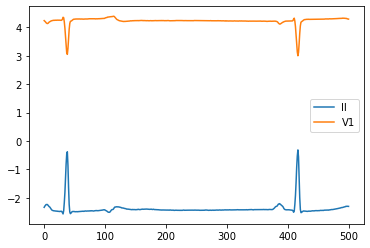

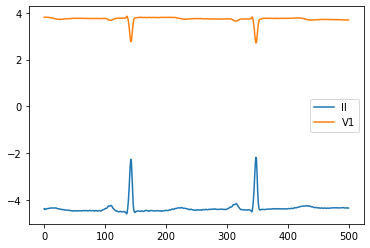

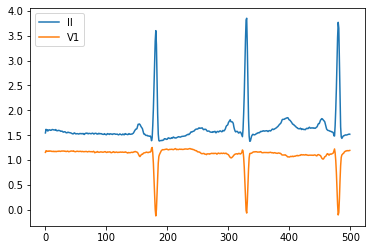

In [24]:
# We selected the same data points from each ECG signal to construct balanced Datasets A–C
# patient 10  # I20 I21 I22  # Coronary artery disease, arterial hypertension, left ventricular hypertrophy
CAD_df_I20 = resample('st-petersburg-incart-12-lead-arrhythmia-database-1.0.0/files/I20', 'atr', ['II', 'V1'], [1,6])
CAD_df_I21 = resample('st-petersburg-incart-12-lead-arrhythmia-database-1.0.0/files/I21', 'atr', ['II', 'V1'], [1,6])
CAD_df_I22 = resample('st-petersburg-incart-12-lead-arrhythmia-database-1.0.0/files/I22', 'atr', ['II', 'V1'], [1,6])

In [25]:
CAD_df = pd.concat([CAD_df_I20, CAD_df_I20, CAD_df_I20, CAD_df_I20, CAD_df_I20, CAD_df_I20, CAD_df_I20,
                    CAD_df_I21, CAD_df_I21, CAD_df_I21, CAD_df_I21, CAD_df_I21, CAD_df_I21, CAD_df_I21, CAD_df_I21,
                    CAD_df_I22, CAD_df_I22, CAD_df_I22, CAD_df_I22, CAD_df_I22, CAD_df_I22, CAD_df_I22, CAD_df_I22])

In [26]:
# CAD case
CAD_df.head()

,II,V1
0,-2.337890,4.234427
1,-2.296775,4.215697
2,-2.272907,4.194646
3,-2.241818,4.164171
4,-2.239353,4.144339


In [27]:
CAD_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10350000 entries, 0 to 449999
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   II      float64
 1   V1      float64
dtypes: float64(2)
memory usage: 236.9 MB


In [28]:
CAD_df.shape[0] // 500

20700

In [29]:
CAD_arr = getSpecificData(CAD_df, 20000, 500)

In [30]:
len(CAD_arr)

20000

In [31]:
len(CAD_arr[0])

1000

In [32]:
CAD_df = pd.DataFrame(CAD_arr)

In [33]:
y_CAD = ['CAD'] * 20000

In [34]:
CAD_df["output"] = y_CAD 

In [35]:
CAD_df.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,output
0,-2.337890,-2.296775,-2.272907,-2.241818,-2.239353,-2.236377,-2.255681,-2.283555,-2.309660,-2.323585,...,4.320015,4.318010,4.316020,4.317262,4.312913,4.309207,4.296886,4.291562,4.287875,CAD
1,-2.304211,-2.304103,-2.304241,-2.304069,-2.304422,-2.309124,-2.312642,-2.312833,-2.317970,-2.321106,...,4.241447,4.244992,4.243301,4.237331,4.241240,4.238497,4.233060,4.237586,4.233267,CAD
2,-2.484505,-2.473755,-2.480738,-2.482431,-2.494080,-2.488301,-2.480502,-2.482233,-2.493075,-2.508120,...,4.280205,4.272279,4.270594,4.267959,4.259370,4.254395,4.250616,4.242121,4.229683,CAD
3,-2.296023,-2.291467,-2.291930,-2.301216,-2.318296,-2.331167,-2.348415,-2.360886,-2.378987,-2.388623,...,4.247363,4.251523,4.251006,4.268991,4.280950,4.291976,4.291004,4.292357,4.294875,CAD
4,-2.628003,-2.626188,-2.628096,-2.630567,-2.626703,-2.612213,-2.612292,-2.618949,-2.618093,-2.607909,...,4.253710,4.254719,4.253341,4.258387,4.254391,4.257962,4.254619,4.257843,4.254659,CAD


In [36]:
CAD_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 1001 entries, 0 to output
dtypes: float64(1000), object(1)
memory usage: 152.7+ MB


#### 3- MI class

Shape of signal Before Resampling =>  (38400, 2)
Shape of signal After Resampling  =>  (9600, 2)


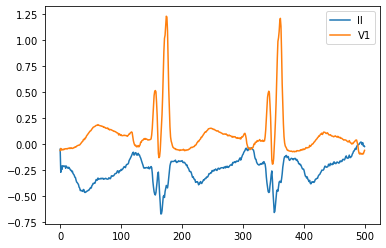

In [37]:
# We selected the same data points from each ECG signal to construct balanced Datasets A–C
MI_df = resample('ptb-diagnostic-ecg-database-1.0.0/patient001/s0010_re', 'xyz', ['II', 'V1'], [1,6])

In [38]:
MI_df = pd.concat([MI_df] * 1053)

In [39]:
MI_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10108800 entries, 0 to 9599
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   II      float64
 1   V1      float64
dtypes: float64(2)
memory usage: 231.4 MB


In [40]:
# MI case
MI_df.head()

,II,V1
0,-0.049288,-0.061747
1,-0.271069,-0.041553
2,-0.212718,-0.056652
3,-0.242930,-0.050297
4,-0.208275,-0.054461


In [41]:
MI_df.shape[0] // 500

20217

In [42]:
MI_arr = getSpecificData(MI_df, 20000, 500)

In [43]:
len(MI_arr)

20000

In [44]:
len(MI_arr[0])

1000

In [45]:
MI_df = pd.DataFrame(MI_arr)

In [46]:
y_MI = ['MI'] * 20000

In [47]:
MI_df["output"] = y_MI

In [48]:
MI_df.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,output
0,-0.049288,-0.271069,-0.212718,-0.242930,-0.208275,-0.215375,-0.212074,-0.214519,-0.210135,-0.232353,...,-0.095536,-0.086044,-0.093981,-0.090505,-0.095818,-0.089985,-0.093954,-0.078235,-0.060191,MI
1,-0.043505,-0.066979,-0.075805,-0.084758,-0.089119,-0.115153,-0.117806,-0.109325,-0.120338,-0.083043,...,0.102919,0.099377,0.094595,0.088896,0.084789,0.090756,0.091411,0.083305,0.075156,MI
2,-0.271260,-0.273840,-0.276350,-0.277866,-0.263484,-0.269523,-0.265556,-0.268881,-0.253661,-0.244301,...,-0.156187,-0.162283,-0.154727,-0.161017,-0.154935,-0.154447,-0.146772,-0.148643,-0.144857,MI
3,-0.250239,-0.253100,-0.265615,-0.266678,-0.288540,-0.306321,-0.310709,-0.320786,-0.321956,-0.323060,...,0.346652,0.401270,0.411713,0.419654,0.329957,0.213559,0.034810,-0.174897,-0.260050,MI
4,-0.341849,-0.436285,-0.551301,-0.578040,-0.535299,-0.494171,-0.404907,-0.390187,-0.406444,-0.351044,...,-0.064580,-0.058984,-0.053046,-0.044271,-0.046518,-0.030961,-0.021675,-0.023863,-0.048204,MI


In [49]:
MI_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 1001 entries, 0 to output
dtypes: float64(1000), object(1)
memory usage: 152.7+ MB


#### 4- CHF class

In [50]:
# CHF case
CHF_df.head()

,ECG1,ECG2
0,0.635,-0.640
1,0.680,-1.280
2,0.630,-1.920
3,0.570,-2.535
4,0.535,-2.800


In [51]:
CHF_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17994491 entries, 0 to 17994490
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   ECG1    float64
 1   ECG2    float64
dtypes: float64(2)
memory usage: 274.6 MB


In [52]:
# so when do balanced dataset we determine 20,000 accordding to smallest dataset 
CHF_df.shape[0] // 500

35988

In [53]:
CHF_arr = getSpecificData(CHF_df, 20000, 500)

In [54]:
len(CHF_arr)

20000

In [55]:
len(CHF_arr[0])

1000

In [56]:
y_CHF = ['CHF'] * 20000

In [57]:
len(y_CHF)

20000

In [58]:
CHF_df = pd.DataFrame(CHF_arr)

In [59]:
CHF_df["output"] = y_CHF 

In [60]:
CHF_df.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,output
0,0.635,0.68,0.630,0.570,0.535,0.510,0.515,0.520,0.525,0.495,...,0.455,0.485,0.505,0.520,0.545,0.580,0.610,0.610,0.645,CHF
1,-0.480,-0.48,-0.455,-0.475,-0.475,-0.475,-0.495,-0.465,-0.465,-0.445,...,0.000,0.000,0.000,0.010,0.020,0.000,0.005,0.000,0.000,CHF
2,-0.400,-0.39,-0.385,-0.365,-0.355,-0.365,-0.325,-0.330,-0.355,-0.355,...,-0.100,-0.085,-0.095,-0.100,-0.090,-0.105,-0.120,-0.115,-0.140,CHF
3,0.770,0.92,1.020,1.055,1.030,0.945,0.830,0.745,0.695,0.675,...,0.505,0.510,0.530,0.555,0.570,0.595,0.620,0.605,0.640,CHF
4,-0.595,-0.63,-0.640,-0.625,-0.615,-0.625,-0.640,-0.640,-0.665,-0.650,...,-0.060,-0.075,-0.060,-0.065,-0.065,-0.050,-0.075,-0.075,-0.055,CHF


In [61]:
CHF_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 1001 entries, 0 to output
dtypes: float64(1000), object(1)
memory usage: 152.7+ MB


### `Create differenet balanced datasets and save them in csvs files`

In [62]:
# two-classification
# three-classification experimental
# four-classification
dataset_A = pd.concat([normal_df, CHF_df])
dataset_B = pd.concat([normal_df, CAD_df, CHF_df])
dataset_C = pd.concat([normal_df, CAD_df, MI_df, CHF_df])

In [63]:
dataset_A.output.unique(), dataset_B.output.unique(), dataset_C.output.unique()

(array(['Normal', 'CHF'], dtype=object),
 array(['Normal', 'CAD', 'CHF'], dtype=object),
 array(['Normal', 'CAD', 'MI', 'CHF'], dtype=object))

In [64]:
dataset_A.shape, dataset_B.shape, dataset_C.shape

((40000, 1001), (60000, 1001), (80000, 1001))

In [65]:
dataset_A.to_csv('D:/4th/GP/balanced_Intra-Patient/dataset_A'+'.csv', index=False)
dataset_B.to_csv('D:/4th/GP/balanced_Intra-Patient/dataset_B'+'.csv', index=False)
dataset_C.to_csv('D:/4th/GP/balanced_Intra-Patient/dataset_C'+'.csv', index=False)

## The End of processing and division balanced datasets for intra-patient